gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

!pip install cellpose

from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

In [1]:
# Import modules
import numpy as np
import time, os, sys, random
from urllib.parse import urlparse
import skimage.io
import matplotlib.pyplot as plt
import matplotlib as mpl
from cellpose import models
from cellpose.io import imread
from cellpose import plot
from skimage.util import img_as_ubyte
import pandas as pd

In [2]:
import scipy
from scipy import ndimage as ndi
import cv2
from skimage.morphology import square, dilation
from sklearn.cluster import KMeans, DBSCAN
# https://stackoverflow.com/questions/19970764/making-feature-vector-from-gabor-filters-for-classification
# https://stackoverflow.com/questions/20608458/gabor-feature-extraction

In [3]:
#------------------------------------------------------
# Number of images we want to read. Only in test phase. If we want to read all images we will use len(Cherry_file) in for loop below
nb_images = 1

# Get path to folders containing images
Image_Directory = "C:/Users/Claudia/Desktop/Master EPFL/machine learning/project_2" + "/test"
#Image_Directory = r"C:\Users\alexi\EPFL\MA3\Machine_learning\20151218_E14_BM_mTF8additionals_4"  #Easier for me (Alexis) than finding of to get my path file nicely
#Image_Directory = "/content/gdrive/MyDrive/ML_2_transcripted_cherry/TF1"
# other folders: 
# \\20151218_E14_BM_mTF8additionals_4

print(Image_Directory)

# Calculate number of document-> array containing 

# Create Lists containing datapath to all images of Cherry/ Ypet files
image_format = "tif"
cherry_condition = "TexasRed"
ypet_condition = "YFP"
Cherry_file = []
Ypet_file = []
test = []

# Walk through directory (call all files) and assign them to proper list
for root, dirs, files in os.walk(Image_Directory, topdown=False): # root = given in Input, dirs = folders, files= files
    for f in files:
        if f.endswith(image_format) and cherry_condition in f: 
            test.append(f)
            Cherry_file.append(os.path.join(root, f))
        elif f.endswith(image_format) and ypet_condition in f: 
            Ypet_file.append(os.path.join(root, f))

#assert len(Cherry_file) != len(Ypet_file), f"There are {len(Cherry_file)} Cherry files and {len(Ypet_file)} Ypet files. The number has to be equal, check manually what's missing"


# Initialize lists containing cherry, ypet images. Length = nb_images or len(Cherry_file) if we want to read all images
cherry_imgs = np.ndarray(nb_images,dtype = np.ndarray)
ypet_imgs = np.ndarray(nb_images,dtype = np.ndarray)


# Read image (We donnot add it in for loop above to enable reading subset of image)
for i in range(nb_images): #len(Cherry_file):
    cherry_imgs[i] = imread(Cherry_file[i])
    ypet_imgs[i] = imread(Ypet_file[i])
    
cherry_imgs = cherry_imgs.tolist()
ypet_imgs = ypet_imgs.tolist()

C:/Users/Claudia/Desktop/Master EPFL/machine learning/project_2/test


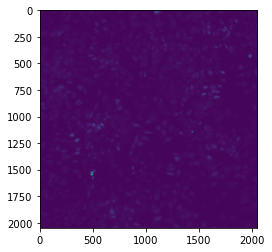

In [4]:
plt.imshow(imread(Ypet_file[0]))

In [ ]:
# Definine parameters for cellpose module using nuclei modus
# https://cellpose.readthedocs.io/en/latest/settings.html
channels = [0,0] # Corresponds to greyscale image
diameter = None # Model was trained on diameters of 17 pixels. None-> automated estimation of the diameter. Can be changed by hand later
flow_threshold = 0.4 # maximum allowed error of the flows for each mask, default = 0.4
gpu = False
model_type='nuclei'

# Set model
model = models.Cellpose(gpu, model_type)

# Nuclei segmentation of all images within cherry_imgs list
masks, flows, styles, diams = model.eval(cherry_imgs, diameter=diameter, channels=channels, flow_threshold=flow_threshold, do_3D=False)


In [ ]:
'''
from cellpose import io
import os
#os.mkdir("/content/gdrive/MyDrive/ML_2_transcripted_cherry/masks_TF1/A_1")
files_names = ["/content/gdrive/MyDrive/ML_2_transcripted_cherry/masks_TF1/A_1/img_"+str(i+1) for i in range(nb_images)]
io.masks_flows_to_seg(cherry_imgs, masks, flows, diams, files_names, channels)'''

In [ ]:
# Display results
image_i = 0 # Number of image we want to display. Max value= nb_images or len(Cherry_file)
fig = plt.figure(figsize=(24,8))
plot.show_segmentation(fig, cherry_imgs[image_i], masks[image_i], flows[image_i][0], channels)
plt.tight_layout()
plt.show()

In [ ]:
# Try with first image: masks[0]
masks_df =  pd.DataFrame(masks[0])   #Putting 1 here (when test_round = 2 completely changes the results)
ypet_df = pd.DataFrame(ypet_imgs[0])
range_s = np.arange(1,masks_df.to_numpy().max())  #IMAGE SPECIFIC: cases where cell are big enough (sell last cell of the notebook)
columnname = ["" for i in range_s]
patch_size = [0 for i in range_s]
mean_intensity = [0 for i in range_s]
sum_intensity = [0 for i in range_s]
median_intensity = [0 for i in range_s]
variance_intensity = [0 for i in range_s]

#cut outliers - per image
assert masks_df.shape == ypet_df.shape, f"Shape of mask is {masks_df.shape} and the shape of ypet image is { ypet_df.shape}. The size has to be the same. Check if normalization is needed"

# Calculate patch size and corresponding ypet signal (mean) and store it into ypet_intensity
for i in range_s : # masks_df.nunique().size 
    columnname[i-1] = "patch_" + str(i)                     #We should not forgot that there is a -1 here.
    patch_size[i-1] = (masks_df == i).values.sum()
    mean_intensity[i-1] = np.nanmean(ypet_df[masks_df==i])
    #sum_intensity[i-1] = np.sum(ypet_df[masks_df==i])
    #median_intensity[i-1] = np.nanmedian(ypet_df[masks_df==i])
    #variance_intensity[i-1] = np.var(ypet_df[masks_df==i])

In [ ]:
#cross validation with polynomial expansion
import matplotlib.pyplot as plt 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV
import statsmodels.formula.api as smf
import seaborn as sns
import re
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import scale
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
import statsmodels.api as sm

In [ ]:
df_train, df_test = train_test_split(ypet_intensity, train_size = 0.8, test_size = 0.2, random_state = 10)

In [ ]:
df_train_x = df_train.drop('patch_size',axis=1)
df_train_y = df_train[['patch_size']]
df_test_x = df_test.drop('patch_size',axis=1)
df_test_y = df_test[['patch_size']]

Visualization of patch_size and mean intensity

In [ ]:
sns.regplot(x="patch_size", y="mean_intensity", data=ypet_intensity, fit_reg=False)

In [ ]:
#model to select
maxdegree = 5 #To define is the maximum degree of the polynomial
cross_validation_ridge_error = np.zeros(maxdegree-1)
cross_validation_lm_error = np.zeros(maxdegree-1)

#see which degree fits data the best for linear regression
for d in range(1, maxdegree):
    #polynomial feature expansion of x_train
    x_poly_train = PolynomialFeatures(degree=d).fit_transform(df_train_x)
    #apply linear regression model and cross-validation for alpha-ridge regression
    lr = LinearRegression()
    rr = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1])
    #apply cross validation
    cve = cross_validate(lr,x_poly_train,df_train_y,scoring='neg_mean_squared_error', cv=5, return_train_score=True)
    crr = cross_validate(rr,x_poly_train,df_train_y,scoring='neg_mean_squared_error', cv=5, return_train_score=True)
    #make array for cross validation with linear model and for ridge regression
    cross_validation_lm_error[d-1] = np.mean(np.absolute(cve['test_score']))
    cross_validation_ridge_error[d-1] = np.mean(np.absolute(crr['test_score']))

In [ ]:
index_min_lm = np.argmin(cross_validation_lm_error)
index_min_ridge = np.argmin(cross_validation_ridge_error)
x_poly_test = PolynomialFeatures(degree=index_min_lm+1).fit_transform(df_test_x)
x_poly_train = PolynomialFeatures(degree=index_min_lm+1).fit_transform(df_train_x)

x_poly_train_df = pd.DataFrame(x_poly_train)
x_poly_test_df = pd.DataFrame(x_poly_test)

#make linear model
model_lm = LinearRegression().fit(x_poly_train_df, df_train_y)
model_ridge = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1]).fit(x_poly_train_df, df_train_y)

#train error
y_train_pred_lm = model_lm.predict(x_poly_train)
mse_train_lm = mean_squared_error(df_train_y,y_train_pred_lm)
y_train_pred_ridge = model_ridge.predict(x_poly_train)
mse_train_ridge = mean_squared_error(df_train_y,y_train_pred_ridge)

#test error
y_test_pred_lm = model_lm.predict(x_poly_test_df)
mse_test_lm = mean_squared_error(df_test_y,y_test_pred_lm)
y_test_pred_ridge = model_ridge.predict(x_poly_test_df)
mse_test_ridge = mean_squared_error(df_test_y,y_test_pred_ridge)

In [ ]:
#show predicted things
plt.plot(df_train_y,df_train_x, 'ro')
plt.plot(y_test_pred_lm,df_test_x, 'ro',color = 'black')
#plt.yscale("log")
#plt.xscale("log")
plt.show()

In [ ]:
#show predicted things
plt.plot(df_train_y,df_train_x, 'ro')
plt.plot(y_test_pred_ridge,df_test_x, 'ro',color = 'black')
#plt.yscale("log")
plt.xscale("log")
plt.show()

In [ ]:
if mse_test_ridge >= mse_test_lm:
    print('take linear regression')
    print('coefficients: ',model_lm.coef_)
    print('intercept: ',model_lm.intercept_)
    
else:
    print('take ridge regression')
    print('coefficients: ',model_ridge.coef_)
    print('intercept: ',model_ridge.intercept_)
    print('alpha: ',model_ridge.alpha_)